In [1]:
%load_ext autoreload
%autoreload 2

import torch
import notebook_setup

device = torch.device('cpu')

/data2/brendan/miniconda3/envs/implicit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Define data distribution and take a sample

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from callbacks import UpdateProgressBarStats
from implicit.datasets import VonMises
from visualization import plot_curve, plot_2d_points

dist = VonMises() # Set data distribution here

points = torch.cat(dist.manifold_points())
densities = dist.prob(points)
data = dist.sample(1000)

lims = {"xlims": (-1.3, 1.3), "ylims": (-1.3, 1.3)} # Set x and y lims for each plot
ebm_lims = torch.Tensor(((-1.5, -1.5), (1.5, 1.5)))

dataloader = data.split(50)
callbacks = [UpdateProgressBarStats(loader=dataloader)]

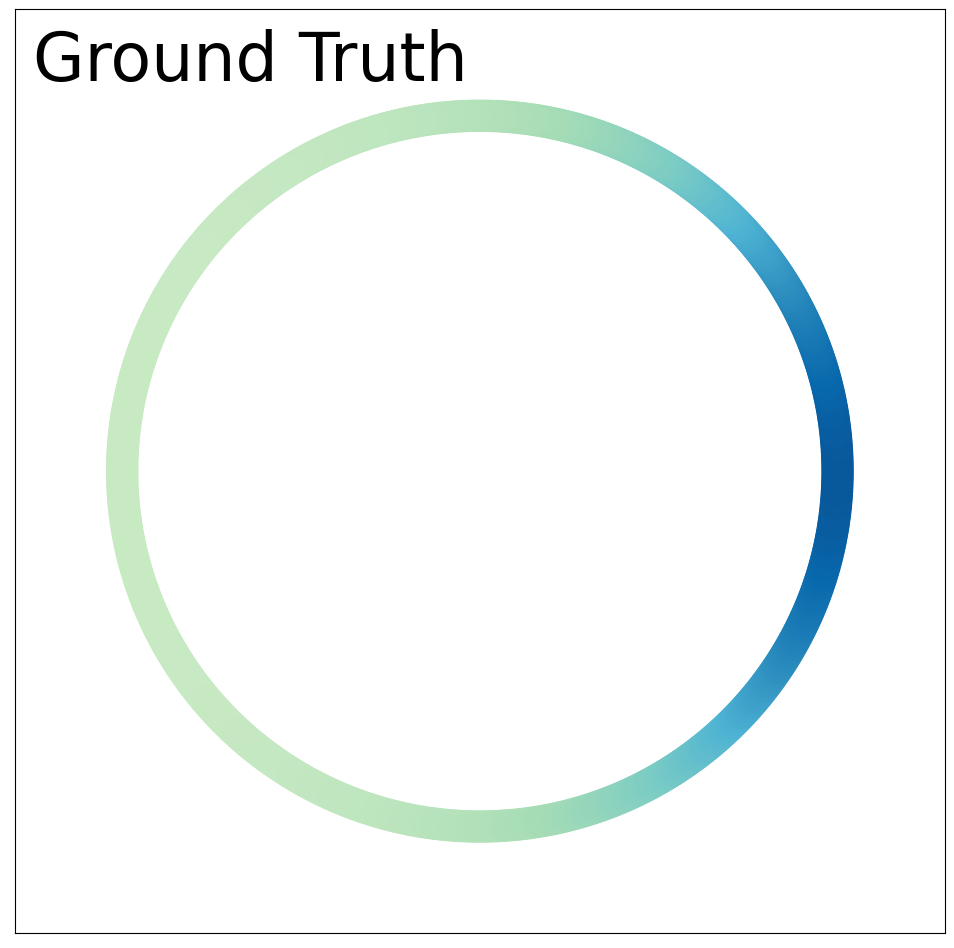

In [3]:
plot_2d_points(points, text="Ground Truth", c=dist.prob(points), darken=0.25, s=500, fontsize=48, **lims)

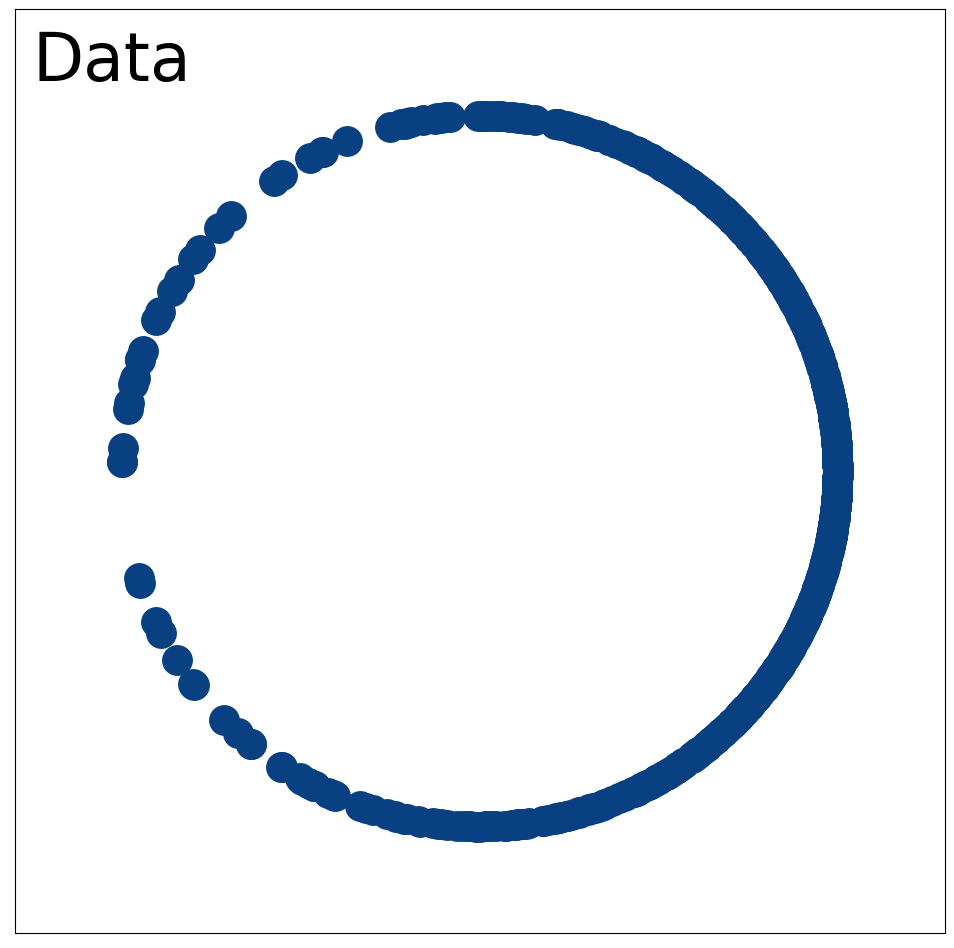

In [4]:
plot_2d_points(data, s=450, text="Data", fontsize=48, **lims)

## EBIM

Initialize a manifold-defining function (MDF).

In [5]:
%%time
from torch import optim
from implicit.maps import FlatSmoothMap
from implicit.models.ebm import ImplicitManifold
from visualization import plot_2d_to_1d_func, COLOURS

mdf = FlatSmoothMap(2, 1, hidden_size=8)
manifold = ImplicitManifold(mdf, ebm_lims, device)

opt = optim.Adam(mdf.parameters(), lr=0.01)

manifold.train(
    optim=opt,
    dataloader=dataloader,
    epochs=300,
    neg_weight=0.3,
    mu=10.,
    sv_min=1.,
    buffer_frac=0.95,
    mc_kwargs={
        "eps": 0.1,
        "alpha": 10,
    },
    callbacks=callbacks,
)

[E300] loss: -0.0122 | pos: 0.0022 | neg: 0.1244 | sv_min: 0.0000 | sv_max: 0.0000 | scale: 0.0229: 100%|██████| 300/300 [03:09<00:00,  1.58it/s]

CPU times: user 3min 6s, sys: 2.06 s, total: 3min 8s
Wall time: 3min 9s


Optimize MDF

In [7]:
from implicit.metrics import distance_to_implicit_manifold

implicit_dists = distance_to_implicit_manifold(data, manifold, opt_steps=100)
implicit_dists.min(), implicit_dists.median(), implicit_dists.mean(), implicit_dists.max()

(tensor(1.0185e-06), tensor(0.0012), tensor(0.0021), tensor(0.0154))

Initialize and train a constrained EBM with the above manifold

In [8]:
%%time
from implicit.models.ebm import ConstrainedEBM

energy = FlatSmoothMap(2, 1, num_layers=2, spectral_norm=False)
ebm = ConstrainedEBM(manifold, energy, lims=ebm_lims, device=device, 
                     line_search_fn="strong_wolfe")

opt = optim.Adam(energy.parameters(), lr=0.01)

ebm.train(
    optim=opt,
    dataloader=dataloader, 
    epochs=20,
    beta=0.1,
    clip_norm=1.,

    buffer_frac=0.95,
    noise_kwargs={
        "opt_steps": 1,
        "line_search_fn": "strong_wolfe",
    },
    mc_kwargs={
        "n_steps": 10,
        "eps": 0.3,
        "alpha": 1,
        "grad_clamp": 0.1,
        "opt_steps": 1,
        "line_search_fn": "strong_wolfe"
    },
    callbacks=callbacks,
)

[E 20] loss: -0.3208 | scale_loss: 3.3637: 100%|█████████████████████████████████████████████████████████████████| 20/20 [02:19<00:00,  6.96s/it]

CPU times: user 2min 50s, sys: 493 ms, total: 2min 50s
Wall time: 2min 21s


Plot resulting energy in ambient space

Plot learned density

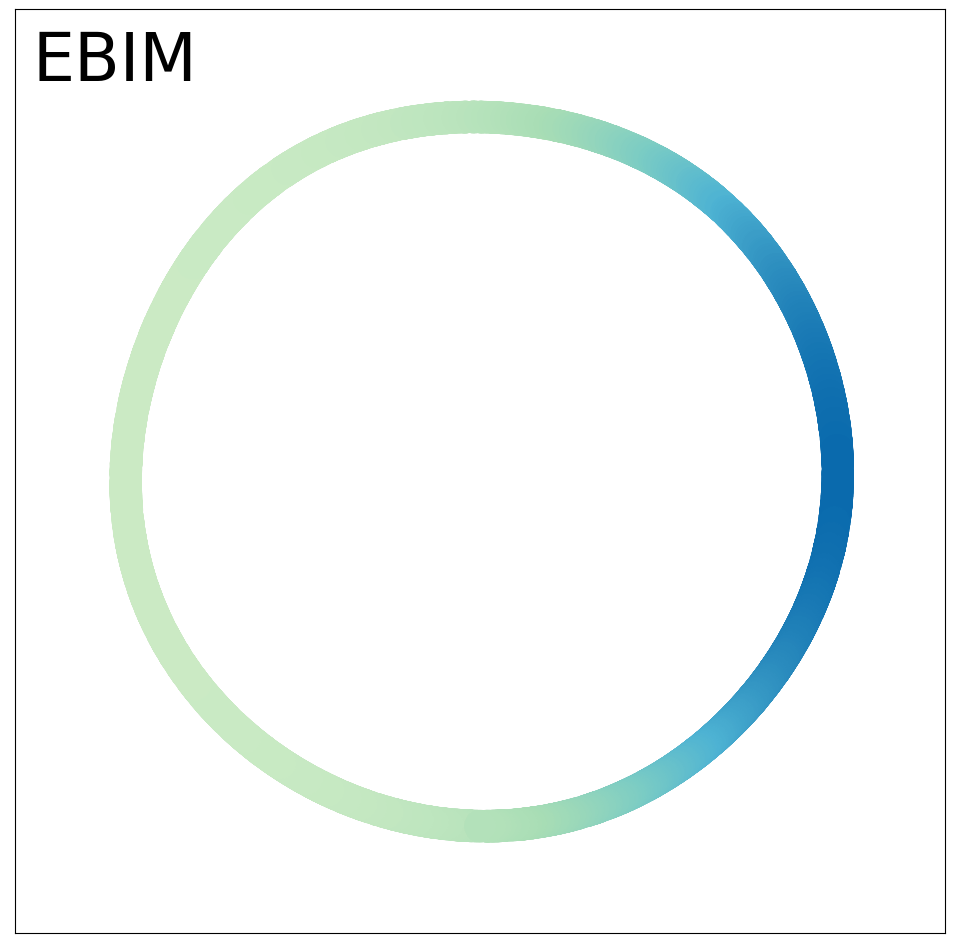

In [9]:
learned_points = ebm.sample_noise(3000, batch_size=3000, line_search_fn="strong_wolfe")

order = torch.argsort(torch.arctan2(learned_points[:,0], learned_points[:,1]))
learned_points = learned_points[order]

with torch.no_grad():
    densities_unnorm = torch.exp(-energy(learned_points)).squeeze()
    partition = torch.mean(densities_unnorm) * (2 * np.pi)
    densities = densities_unnorm / partition
    
plot_2d_points(learned_points, c=densities, darken=0.25, s=500, text="EBIM", fontsize=48, **lims)

In [13]:
from implicit.metrics import compute_discretized_wasserstein

gt_points = torch.cat(dist.manifold_points())
gt_densities = dist.prob(gt_points)

compute_discretized_wasserstein(
    learned_points,
    densities,
    gt_points,
    gt_densities,
    **lims
)

0.0009758514745651624

# Pushforward EBM

Initialize and train an autoencoder with latent EBM

In [14]:
%%time
from itertools import chain
from implicit.models.ebm import PushforwardEBM
from implicit.models.autoencoder import Autoencoder

encoder = FlatSmoothMap(2, 1)
decoder = FlatSmoothMap(1, 2)
latent_energy = FlatSmoothMap(1, 1, spectral_norm=False)

ae = Autoencoder(encoder, decoder, device=device)
ae_ebm = PushforwardEBM(ae, latent_energy, device=device)

ae_ebm.train_ae(
    optim=optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=0.001),
    dataloader=dataloader, 
    epochs=300,
    clip_norm=1.,
    callbacks=callbacks,
)

[E146] loss: 0.0000:  49%|█████████████████████████████████████████▎                                           | 146/300 [00:09<00:10, 15.32it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
from implicit.metrics import distance_to_pushforward_manifold

ae_dists = distance_to_pushforward_manifold(data, ae_ebm.autoencoder, opt_steps=100)
ae_dists.min(), ae_dists.median(), ae_dists.mean(), ae_dists.max()

(tensor(3.5187e-06), tensor(0.0027), tensor(0.0033), tensor(0.1531))

In [16]:
%%time

ae_ebm.train_ebm(
    optim=optim.Adam(latent_energy.parameters(), lr=0.01),
    dataloader=dataloader, 
    epochs=200, 
    beta=0.1,
    clip_norm=1.,
    
    buffer_frac=0.95,  
    mc_kwargs={
        "n_steps": 20,
        "eps": 0.5,
        "alpha": 10,
    },
    callbacks=callbacks,
)

[E142] loss: -0.8177 | scale_loss: 9.5362:  71%|████████████████████████████████████████████▋                  | 142/200 [03:45<02:46,  2.87s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Plot learned density

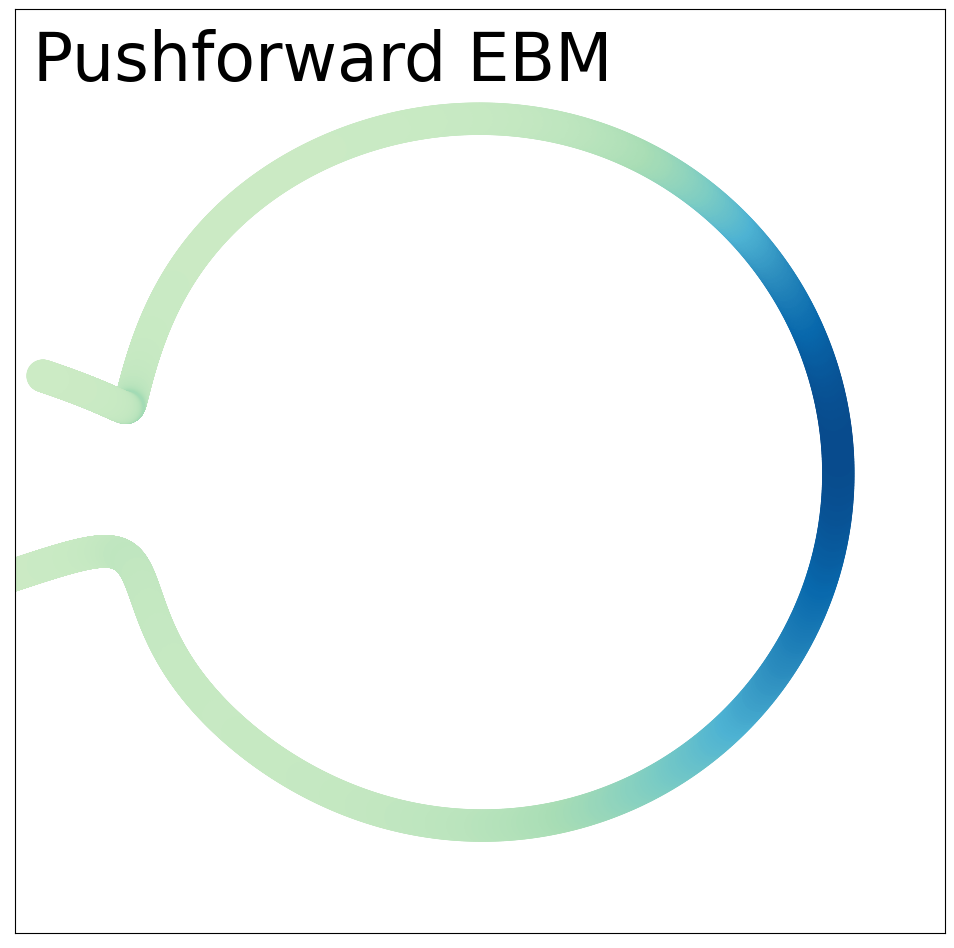

In [17]:
with torch.no_grad():
    lower, upper = ae_ebm.ebm.lims
    lattice = torch.linspace(lower[0].tolist(), upper[0].tolist(), 3000)[:, None]
    
    densities = ae_ebm.prob(z=lattice).squeeze()
    points = ae_ebm.decoder(lattice)
    
plot_2d_points(points, c=densities, darken=0.25, s=500, text="Pushforward EBM", fontsize=48, **lims)

In [18]:
compute_discretized_wasserstein(
    np.array(points),
    np.array(densities),
    gt_points,
    gt_densities,
    **lims
)

0.0013361185988907051